In [1]:
from scipy.sparse import csr_matrix

import seml
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
results = seml.get_results("moscot_map2", to_data_frame=True)

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

In [3]:
results.columns

Index(['_id', 'config.overwrite', 'config.db_collection', 'config.dataset',
       'config.method', 'config.params.alpha', 'config.params.epsilon',
       'config.path_data', 'config.path_results', 'config.seed', 'result.time',
       'result.method', 'result.method_info.converged',
       'result.method_info.cost', 'result.adata_sc_size',
       'result.adata_sp_size', 'result.gene_size', 'result.corr_results_mean',
       'result.corr_results_median', 'result.corr_results_var',
       'result.corr_results_max', 'result.corr_results_min',
       'config.params.learning_rate', 'config.params.num_epochs',
       'result.method_info.kl_reg', 'config.params.epochs',
       'config.params.n_latent', 'result.method_info'],
      dtype='object')

In [4]:
columns = [
    "config.params.alpha",
    "config.params.epsilon",
    "config.params.learning_rate",
    "config.params.learning_rate",
    "config.params.num_epochs",
    "config.params.epochs",
    "config.params.n_latent",
]
results["unique_config"] = results[columns].apply(
    lambda x: "".join(str(x)).replace(" ", ""), axis=1, raw=True
)
# results["unique_config"] = results[columns].apply(lambda x: "-".join(str(x)), axis=0)
# results["unique_config"]

In [5]:
results["corrvalue"] = [pd.Series(["pearson", "spearman"]) for i in range(len(results))]
results["size"] = results["result.adata_sp_size"] + results["result.adata_sc_size"]
cols = [
    "config.method",
    "result.time",
    "size",
    "config.params.epsilon",
    "config.params.alpha",
    "config.dataset",
    "unique_config",
]
cols_explode = [
    "result.corr_results_mean",
    "result.corr_results_var",
    "result.corr_results_median",
    "corrvalue",
]
corr_df = results[cols + cols_explode].explode(cols_explode)
corr_df.columns = [
    "method",
    "time",
    "n_cells",
    "epsilon",
    "alpha",
    "dataset",
    "unique_config",
    "mean_corr",
    "var_corr",
    "median_corr",
    "corrvalue",
]

In [6]:
corr_df

,method,time,n_cells,epsilon,alpha,dataset,unique_config,mean_corr,var_corr,median_corr,corrvalue
0,MOSCOT,8.299602,2064,0.01,0.1,30,[0.10.01nannannannannan],0.258188,0.045292,0.237774,pearson
0,MOSCOT,8.299602,2064,0.01,0.1,30,[0.10.01nannannannannan],0.206143,0.037312,0.150178,spearman
1,MOSCOT,6.959309,2064,0.01,0.5,30,[0.50.01nannannannannan],0.25493,0.038163,0.243571,pearson
1,MOSCOT,6.959309,2064,0.01,0.5,30,[0.50.01nannannannannan],0.200345,0.032033,0.15448,spearman
2,MOSCOT,6.031179,2064,0.01,0.9,30,[0.90.01nannannannannan],0.11733,0.014087,0.097912,pearson
...,...,...,...,...,...,...,...,...,...,...,...
621,GIMVI,260.191044,9852,NaN,NaN,39,[nannannannannan400.20.],-0.021951,0.000896,-0.022584,spearman
622,GIMVI,408.327757,9852,NaN,NaN,39,[nannannannannan600.10.],-0.004712,0.000343,-0.006086,pearson
622,GIMVI,408.327757,9852,NaN,NaN,39,[nannannannannan600.10.],-0.013952,0.000681,-0.014574,spearman
623,GIMVI,473.665889,9852,NaN,NaN,39,[nannannannannan600.20.],-0.006735,0.000373,-0.008771,pearson


In [7]:
corr_df.n_cells.unique().shape

(13,)

In [8]:
corr_df[corr_df.method.isin(["MOSCOT"])].groupby(["epsilon", "alpha"])[
    ["mean_corr", "median_corr"]
].mean()

mean_corr  median_corr
epsilon alpha                        
0.005   0.1     0.179423     0.154686
        0.5     0.177216     0.154467
        0.9     0.094551     0.082125
0.010   0.1     0.179201     0.155492
        0.5     0.188378     0.166242
        0.9     0.099522     0.087914

In [9]:
corr_df["method"] = corr_df["method"].replace(
    {"MOSCOT": "moscot", "GIMVI": "gimVI", "TANGRAM": "Tangram"}
)

In [10]:
gimvi = corr_df[corr_df.method == "gimVI"].reset_index()
tangram = corr_df[corr_df.method == "Tangram"].reset_index()
cond = (
    corr_df.method == "moscot"
)  # (corr_df.epsilon == 0.01) & (corr_df.alpha == 0.5) & (corr_df.method == "moscot")
moscot = corr_df[cond].reset_index()

In [11]:
final_df = pd.concat([gimvi, tangram, moscot]).reset_index()
# final_df = final_df.groupby(["method", "dataset"]).mean(["mean_corr"]).reset_index()
final_df

,level_0,index,method,time,n_cells,epsilon,alpha,dataset,unique_config,mean_corr,var_corr,median_corr,corrvalue
0,0,390,gimVI,36.819408,2064,NaN,NaN,30,[nannannannannan200.10.],-0.013,0.002051,-0.013366,pearson
1,1,390,gimVI,36.819408,2064,NaN,NaN,30,[nannannannannan200.10.],-0.009504,0.002127,-0.003136,spearman
2,2,391,gimVI,35.652000,2064,NaN,NaN,30,[nannannannannan200.20.],-0.010708,0.001988,-0.013665,pearson
3,3,391,gimVI,35.652000,2064,NaN,NaN,30,[nannannannannan200.20.],-0.007597,0.002018,-0.007841,spearman
4,4,392,gimVI,67.760686,2064,NaN,NaN,30,[nannannannannan400.10.],-0.012134,0.002046,-0.017972,pearson
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,499,249,moscot,26.308783,9852,0.005,0.1,39,[0.10.005nannannannannan],0.067423,0.003831,0.042514,spearman
1244,500,250,moscot,17.485334,9852,0.005,0.5,39,[0.50.005nannannannannan],0.006251,0.000556,-0.000656,pearson
1245,501,250,moscot,17.485334,9852,0.005,0.5,39,[0.50.005nannannannannan],0.054544,0.00261,0.033663,spearman
1246,502,251,moscot,12.384511,9852,0.005,0.9,39,[0.90.005nannannannannan],0.006534,0.000687,-0.000994,pearson


In [12]:
final_df["ones"] = 1
final_df = final_df[final_df.corrvalue == "spearman"].copy()

In [13]:
all_datasets = (
    final_df[["method", "dataset", "ones"]].groupby(["dataset"]).count().reset_index()
)
datasets = all_datasets.dataset.unique()
# datasets = all_datasets[all_datasets.method == 9].dataset.unique()

In [14]:
all_datasets

,dataset,method,ones
0,1,54,54
1,3,36,36
2,14,54,54
3,20,42,42
4,21,48,48
5,22,48,48
6,26,36,36
7,30,42,42
8,32,42,42
9,33,42,42


In [15]:
plot_df = final_df[final_df.dataset.isin(datasets)].copy()
plot_df

,level_0,index,method,time,n_cells,epsilon,alpha,dataset,unique_config,mean_corr,var_corr,median_corr,corrvalue,ones
1,1,390,gimVI,36.819408,2064,NaN,NaN,30,[nannannannannan200.10.],-0.009504,0.002127,-0.003136,spearman,1
3,3,391,gimVI,35.652000,2064,NaN,NaN,30,[nannannannannan200.20.],-0.007597,0.002018,-0.007841,spearman,1
5,5,392,gimVI,67.760686,2064,NaN,NaN,30,[nannannannannan400.10.],-0.007937,0.002217,-0.005954,spearman,1
7,7,393,gimVI,78.099815,2064,NaN,NaN,30,[nannannannannan400.20.],-0.006315,0.002045,-0.005892,spearman,1
9,9,394,gimVI,95.171204,2064,NaN,NaN,30,[nannannannannan600.10.],-0.007466,0.002126,-0.00264,spearman,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,495,247,moscot,13.929297,9852,0.010,0.5,39,[0.50.01nannannannannan],0.054827,0.002698,0.033606,spearman,1
1241,497,248,moscot,16.392304,9852,0.010,0.9,39,[0.90.01nannannannannan],0.025922,0.001476,0.017156,spearman,1
1243,499,249,moscot,26.308783,9852,0.005,0.1,39,[0.10.005nannannannannan],0.067423,0.003831,0.042514,spearman,1
1245,501,250,moscot,17.485334,9852,0.005,0.5,39,[0.50.005nannannannannan],0.054544,0.00261,0.033663,spearman,1


In [16]:
list_df = []
for d in plot_df.dataset.unique():
    for m in plot_df.method.unique():
        cond = (plot_df.dataset == d) & (plot_df.method == m)
        temp_df = plot_df[cond].copy()
        top_config = temp_df[["unique_config", "median_corr"]].groupby("unique_config")
        # top_config = (top_config
        #     .sort_values(by=["median_corr"], ascending=False)
        #     # .index[0]
        # )
        # list_df.append(temp_df[temp_df["unique_config"].isin([top_config])].copy())
        list_df.append(temp_df)
best_df = pd.concat(list_df)

In [17]:
temp_df[["unique_config", "median_corr"]].groupby("unique_config").median()

,median_corr
unique_config,
[0.10.005nannannannannan],0.084199
[0.10.01nannannannannan],0.082481
[0.50.005nannannannannan],0.079269
[0.50.01nannannannannan],0.086966
[0.90.005nannannannannan],0.076386
[0.90.01nannannannannan],0.094311


In [18]:
top_config.sort_values(by=["median_corr"], ascending=False)

AttributeError: 'DataFrameGroupBy' object has no attribute 'sort_values'

In [83]:
temp_df[["unique_config", "median_corr"]].groupby("unique_config").median().sort_values(
    by="median_corr", ascending=False
)
# temp_df[temp_df["unique_config"].isin([top_config])].copy()

,median_corr
unique_config,
[0.90.01nannannannannan],0.094311
[0.50.01nannannannannan],0.086965
[0.10.005nannannannannan],0.084203
[0.10.01nannannannannan],0.082489
[0.50.005nannannannannan],0.079263
[0.90.005nannannannannan],0.076385


In [69]:
top_config = (
    list_df[0][["unique_config", "median_corr"]]
    .groupby("unique_config")
    .median()
    .sort_values(by="median_corr", ascending=False)
    .index[0]
)

In [71]:
top_config

'[nannannannannan400.10.]'

In [31]:
best_df

,level_0,index,method,time,n_cells,epsilon,alpha,dataset,mean_corr,var_corr,median_corr,corrvalue,ones
1,1,390,gimVI,39.834431,2064,NaN,NaN,30,-0.009627,0.002091,-0.005122,spearman,1
3,3,391,gimVI,40.712392,2064,NaN,NaN,30,-0.008805,0.002107,-0.010395,spearman,1
5,5,392,gimVI,83.848295,2064,NaN,NaN,30,-0.006971,0.002112,-0.006428,spearman,1
7,7,393,gimVI,88.715282,2064,NaN,NaN,30,-0.006315,0.002045,-0.005892,spearman,1
9,9,394,gimVI,112.317461,2064,NaN,NaN,30,-0.007992,0.002178,-0.002674,spearman,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,315,157,moscot,11.918431,3585,0.010,0.5,3,0.06765,0.001117,0.065809,spearman,1
1061,317,158,moscot,10.657839,3585,0.010,0.9,3,0.078969,0.002025,0.061936,spearman,1
1063,319,159,moscot,9.960689,3585,0.005,0.1,3,0.076132,0.001013,0.084203,spearman,1
1065,321,160,moscot,13.105308,3585,0.005,0.5,3,0.056557,0.000743,0.052307,spearman,1


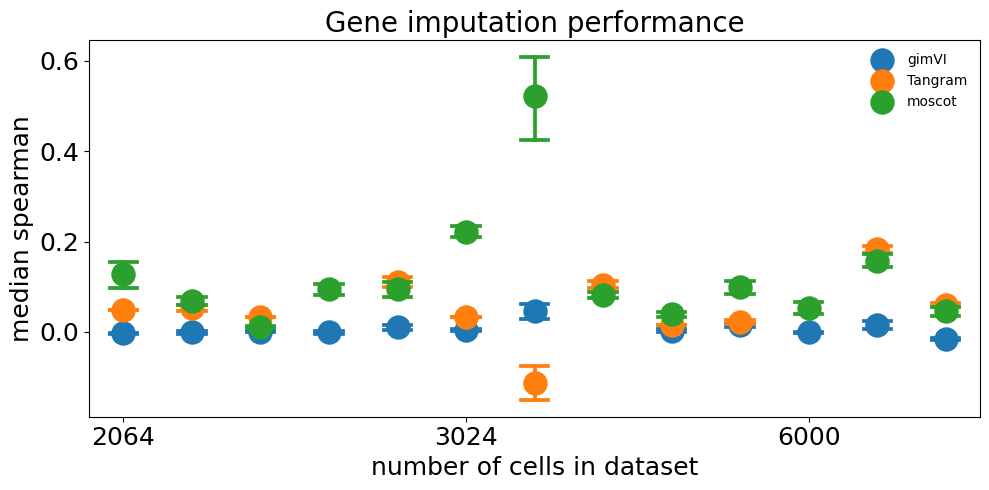

In [24]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# g = sns.boxplot(
#     data=final_df[final_df.corrvalue == "spearman"],
#     x="n_cells",
#     y="median",
#     hue="method",
#     dodge=True,
#     ax=ax,
# )

sns.pointplot(
    data=final_df[final_df.dataset.isin(datasets)],
    x="n_cells",
    y="median_corr",
    hue="method",
    dodge=False,
    jitter=1.5,
    # s=50,
    scale=2,
    linestyles="",
    edgecolors="black",
    capsize=0.4,
    linewidth=1,
    ax=ax,
)
legend = plt.legend()

legend.get_frame().set_facecolor("none")
legend.get_frame().set_edgecolor("white")
ticks, labels = plt.xticks()
plt.xticks(ticks[::5], labels[::5])

ax.set_ylabel("median spearman", fontsize=18)

ax.set_xlabel("number of cells in dataset", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.set_title("Gene imputation performance", fontsize=20)
plt.tight_layout()

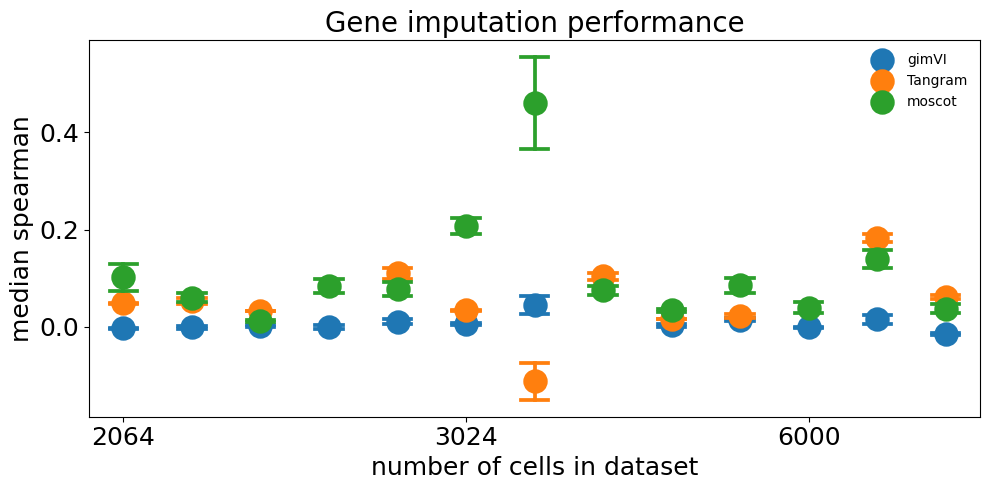

In [35]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# g = sns.boxplot(
#     data=final_df[final_df.corrvalue == "spearman"],
#     x="n_cells",
#     y="median",
#     hue="method",
#     dodge=True,
#     ax=ax,
# )

sns.pointplot(
    data=final_df[final_df.dataset.isin(datasets)],
    x="n_cells",
    y="median_corr",
    hue="method",
    dodge=False,
    jitter=1.5,
    # s=50,
    scale=2,
    linestyles="",
    edgecolors="black",
    capsize=0.4,
    linewidth=1,
    ax=ax,
)
legend = plt.legend()

legend.get_frame().set_facecolor("none")
legend.get_frame().set_edgecolor("white")
ticks, labels = plt.xticks()
plt.xticks(ticks[::5], labels[::5])

ax.set_ylabel("median spearman", fontsize=18)

ax.set_xlabel("number of cells in dataset", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.set_title("Gene imputation performance", fontsize=20)
plt.tight_layout()

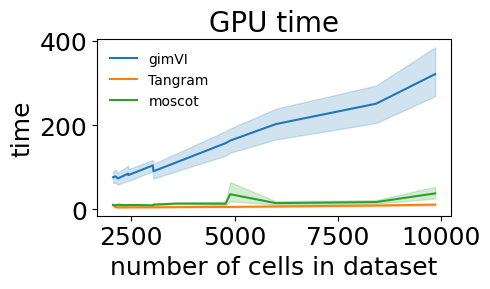

In [36]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
# g = sns.boxplot(
#     data=final_df[final_df.corrvalue == "spearman"],
#     x="n_cells",
#     y="median",
#     hue="method",
#     dodge=True,
#     ax=ax,
# )

sns.lineplot(
    data=final_df[final_df.corrvalue == "spearman"],
    x="n_cells",
    y="time",
    hue="method",
    ax=ax,
)
legend = plt.legend()

legend.get_frame().set_facecolor("none")
legend.get_frame().set_edgecolor("white")
# ticks, labels = plt.xticks()
# plt.xticks(ticks[::5], labels[::5])

ax.set_ylabel("time", fontsize=18)

ax.set_xlabel("number of cells in dataset", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.set_title("GPU time", fontsize=20)
plt.tight_layout()

In [37]:
moscot[moscot.median_corr.values > 0.5]

,index,method,time,n_cells,epsilon,alpha,dataset,mean_corr,var_corr,median_corr,corrvalue
252,126,moscot,7.298270,3039,0.010,0.5,14,0.786442,0.00755,0.78233,pearson
253,126,moscot,7.298270,3039,0.010,0.5,14,0.634498,0.013679,0.642116,spearman
256,128,moscot,8.491015,3039,0.005,0.5,14,0.769201,0.008271,0.761922,pearson
257,128,moscot,8.491015,3039,0.005,0.5,14,0.627835,0.013241,0.631772,spearman
260,130,moscot,8.814041,3039,0.001,0.5,14,0.743841,0.008833,0.737949,pearson
261,130,moscot,8.814041,3039,0.001,0.5,14,0.619977,0.012773,0.618275,spearman
262,131,moscot,24.484198,3039,0.001,0.9,14,0.585494,0.016605,0.531633,pearson
263,131,moscot,24.484198,3039,0.001,0.9,14,0.505479,0.008572,0.520357,spearman
264,132,moscot,6.702712,3039,0.010,0.5,14,0.816315,0.010985,0.867277,pearson
265,132,moscot,6.702712,3039,0.010,0.5,14,0.623775,0.033326,0.636835,spearman


In [38]:
from pathlib import Path
import scanpy as sc
import anndata as ad
import squidpy as sq
import numpy as np

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")
path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 14
seed = 42
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()

# test_var = rng.choice(adata_sp.var_names, n_genes, replace=False).tolist()
# train_var = adata_sp_a.var_names[~np.in1d(adata_sp_a.var_names, test_var)].tolist()
# true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

# adata_sp_a_train = adata_sp_a[:, train_var].copy()
# adata_sp_b_train = adata_sp_b[:, train_var].copy()

# sc.tl.pca(adata_sp_b_train)
# sc.tl.pca(adata_sp_a_train)
# adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

In [16]:
adata_sp.obsm["spatial_2D_"] = adata_sp.obsm["spatial"][:, [0, 2]]

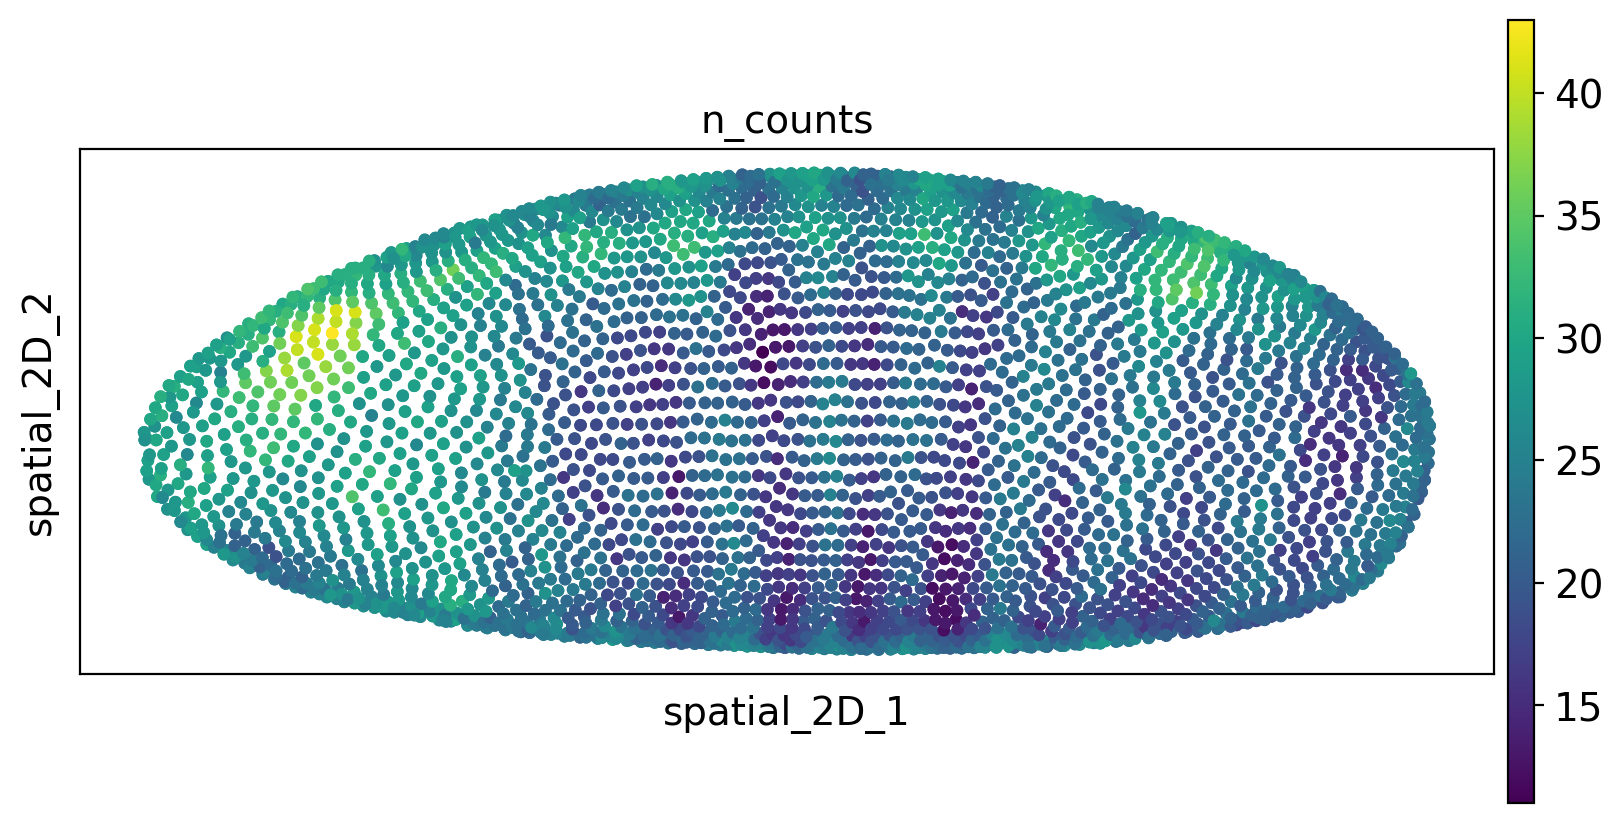

In [17]:
sc.set_figure_params(figsize=(8, 4), dpi=100)
sq.pl.spatial_scatter(
    adata_sp, color="n_counts", spatial_key="spatial_2D_", shape=None, size=50
)

In [18]:
adata_sp.obsm["spatial_2D_"] = adata_sp.obsm["spatial"][:, [1, 2]]

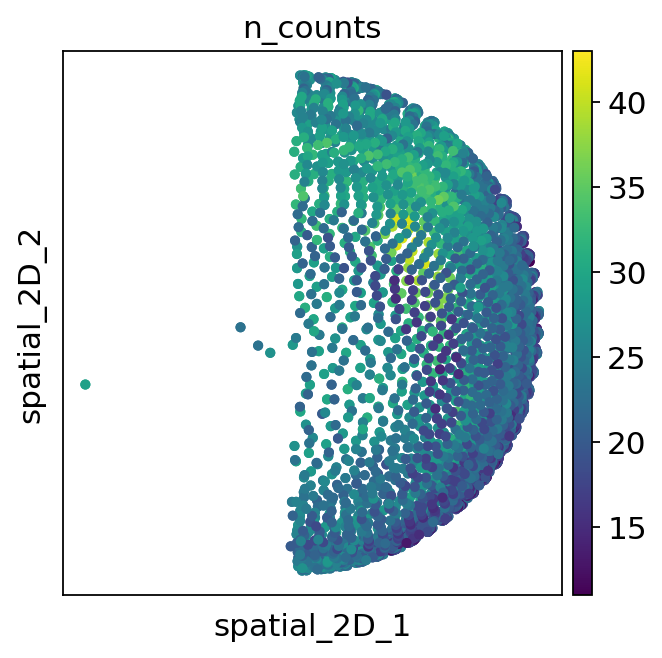

In [19]:
sc.set_figure_params(figsize=(8, 4))
sq.pl.spatial_scatter(
    adata_sp, color="n_counts", spatial_key="spatial_2D_", shape=None, size=50
)

In [62]:
moscot[moscot.n_cells.values > 5000].dataset.unique()

array([ 1, 39, 41])

In [63]:
from pathlib import Path
import scanpy as sc
import anndata as ad
import squidpy as sq
import numpy as np

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")
path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 41
seed = 42
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()
# test_var = rng.choice(adata_sp.var_names, n_genes, replace=False).tolist()
# train_var = adata_sp_a.var_names[~np.in1d(adata_sp_a.var_names, test_var)].tolist()
# true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

# adata_sp_a_train = adata_sp_a[:, train_var].copy()
# adata_sp_b_train = adata_sp_b[:, train_var].copy()

# sc.tl.pca(adata_sp_b_train)
# sc.tl.pca(adata_sp_a_train)
# adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

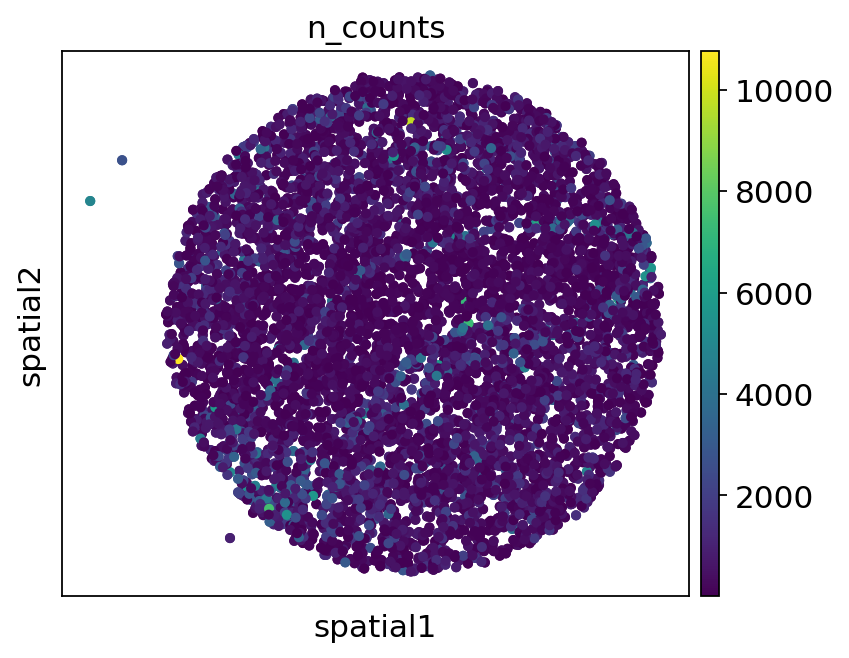

In [64]:
sc.set_figure_params(figsize=(8, 4))
sq.pl.spatial_scatter(
    adata_sp, color="n_counts", spatial_key="spatial", shape=None, size=50
)